# 📱 중고 휴대폰 가격 예측 (TabNet)

이 노트북은 **TabNet (Tabular Network)** 딥러닝 모델을 사용하여 **중고 휴대폰의 가격(`normalized_used_price`)을 예측**하는 예제입니다.

## 🚀 프로세스 개요
1. **라이브러리 설치**: 필요한 도구들을 설치합니다.
2. **데이터 로드**: CSV 파일을 불러옵니다.
3. **데이터 전처리**: 결측치를 채우고, 글자(범주형) 데이터를 숫자로 변환합니다.
4. **데이터 분할**: 학습용, 검증용, 테스트용 데이터로 나눕니다.
5. **모델 학습**: TabNet 모델을 만들고 학습시킵니다.
6. **결과 시각화**: 학습 과정과 예측 결과를 그래프로 확인합니다.

## 1. 📚 라이브러리 설치
TabNet을 사용하기 위해 `pytorch-tabnet` 라이브러리를 설치합니다. 이미 설치되어 있다면 건너뛰어도 됩니다.

In [1]:
# 필요한 라이브러리 설치
!pip install pytorch-tabnet pandas numpy scikit-learn matplotlib seaborn torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 한글 폰트 설정 (필요시 운영체제에 맞게 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.20.2-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB)
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
    --------------------------------------- 1.6/110.9 MB 9.0 MB/s eta 0:00:13
   - -------------------------------------- 4.7/110.9 MB 12.7 MB/s eta 0:00:09
   -- ------------------------------------- 7.3/110.9 MB 12.4 MB/s eta 0:00:09
   --- -------------------------------

## 2. 💿 데이터 로드
데이터셋을 불러오고 상위 5개 행을 확인합니다.

In [2]:
# 데이터 로드
file_path = 'used_device_data.csv'  # 파일 경로가 같은 폴더에 있다고 가정
df = pd.read_csv(file_path)

# 데이터 확인
print(f"데이터 크기: {df.shape}")
df.head()

데이터 크기: (3454, 15)


,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


## 3. 🧹 데이터 전처리
딥러닝 모델에 넣기 좋게 데이터를 다듬는 과정입니다.

1. **결측치(NaN) 처리**: 
   - 숫자는 평균값(Mean)으로 채웁니다.
   - 문자는 최빈값(Mode, 가장 많이 등장하는 값)으로 채웁니다.
2. **범주형 데이터 인코딩 (Label Encoding)**:
   - `Samsung`, `Apple` 같은 브랜드나 `Android`, `iOS` 같은 OS는 컴퓨터가 이해할 수 있는 숫자(0, 1, 2...)로 바꿔줍니다.
3. **TabNet 설정 준비**:
   - 범주형 변수가 **몇 번째 컬럼**에 있는지(`cat_idxs`), **종류가 몇 개**인지(`cat_dims`) 파악해야 합니다.

In [3]:
from sklearn.preprocessing import LabelEncoder

# 1. 결측치 자동 채우기
for col in df.columns:
    if df[col].dtype == 'object':
        # 범주형(문자): 최빈값으로 채우기
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        # 수치형(숫자): 평균값으로 채우기
        df[col] = df[col].fillna(df[col].mean())

# 2. 범주형 변수 식별 및 Label Encoding
categorical_columns = []
categorical_dims = {}  # {컬럼명: 고유값 개수}

for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        categorical_columns.append(col)
        categorical_dims[col] = len(le.classes_)

print("범주형 변수들:", categorical_columns)

# 3. TabNet을 위한 cat_idxs, cat_dims 준비
features = [col for col in df.columns if col not in ['normalized_used_price']]
target = 'normalized_used_price'

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print("범주형 변수 인덱스(cat_idxs):", cat_idxs)
print("범주형 변수 개수(cat_dims):", cat_dims)

범주형 변수들: ['device_brand', 'os', '4g', '5g']
범주형 변수 인덱스(cat_idxs): [0, 1, 3, 4]
범주형 변수 개수(cat_dims): [34, 4, 2, 2]


## 4. ✂️ 데이터 분할
전체 데이터를 **학습(Train) : 검증(Valid) : 테스트(Test)** 세트로 나눕니다.
- **Train (70%)**: 모델이 공부하는 데이터
- **Valid (15%)**: 공부가 잘 되고 있는지 중간 점검하는 데이터
- **Test (15%)**: 최종 시험 데이터

In [4]:
from sklearn.model_selection import train_test_split

X = df[features].values
y = df[target].values.reshape(-1, 1)

# 전체 데이터를 Train(70%) / Rest(30%)로 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Rest(30%)를 Valid(15%) / Test(15%)로 다시 반씩 분할
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"학습 데이터 크기: {X_train.shape}")
print(f"검증 데이터 크기: {X_valid.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

학습 데이터 크기: (2417, 14)
검증 데이터 크기: (518, 14)
테스트 데이터 크기: (519, 14)


## 5. 🧠 모델 학습 (TabNet)
TabNetRegressor 모델을 생성하고 학습을 시작합니다.
- `optimizer_fn`: 최적화 알고리즘 (Adam)
- `scheduler_params`: 학습률을 점진적으로 줄여서 더 정교하게 학습하도록 함
- `fit()`: 실제 학습을 수행하는 함수. `max_epochs`는 학습 반복 횟수입니다.

In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor

# 모델 정의
clf = TabNetRegressor(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,      # 범주형 변수를 임베딩할 차원 크기
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'  # 특성 선택에 사용할 마스킹 함수
)

# 모델 학습
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],      # 평가지표: RMSE
    max_epochs=100,            # 최대 100번 반복 학습
    patience=20,               # 20번 동안 성능 향상이 없으면 조기 종료
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

c:\Users\UserK\machin_learning\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 14.29703| train_rmse: 969.58113| valid_rmse: 969.58771|  0:00:01s
epoch 1  | loss: 6.63085 | train_rmse: 86.00141| valid_rmse: 87.19527|  0:00:02s
epoch 2  | loss: 2.92477 | train_rmse: 50.8641 | valid_rmse: 51.44635|  0:00:03s
epoch 3  | loss: 1.02041 | train_rmse: 148.47699| valid_rmse: 149.67654|  0:00:04s
epoch 4  | loss: 0.5808  | train_rmse: 217.25403| valid_rmse: 218.70007|  0:00:06s
epoch 5  | loss: 0.31465 | train_rmse: 20.67667| valid_rmse: 20.53577|  0:00:07s
epoch 6  | loss: 0.20954 | train_rmse: 15.44871| valid_rmse: 15.75081|  0:00:08s
epoch 7  | loss: 0.18847 | train_rmse: 33.60805| valid_rmse: 34.03052|  0:00:08s
epoch 8  | loss: 0.16333 | train_rmse: 37.76722| valid_rmse: 37.61904|  0:00:09s
epoch 9  | loss: 0.14045 | train_rmse: 32.60922| valid_rmse: 32.51002|  0:00:09s
epoch 10 | loss: 0.12311 | train_rmse: 31.06437| valid_rmse: 31.21151|  0:00:10s
epoch 11 | loss: 0.11327 | train_rmse: 29.28862| valid_rmse: 29.56196|  0:00:10s
epoch 12 | loss: 0.111

c:\Users\UserK\machin_learning\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6. 📊 결과 시각화
모델이 얼마나 잘 학습했는지, 어떤 변수가 중요한지 확인해봅니다.

1. **Loss Graph**: 학습이 진행될수록 오차(Loss)가 줄어드는지 확인
2. **Scatter Plot**: 실제 가격과 예측 가격이 얼마나 일치하는지 확인 (대각선에 가까울수록 좋음)
3. **Feature Importance**: 가격 결정에 어떤 스펙(RAM, 카메라 등)이 중요한 역할을 했는지 확인

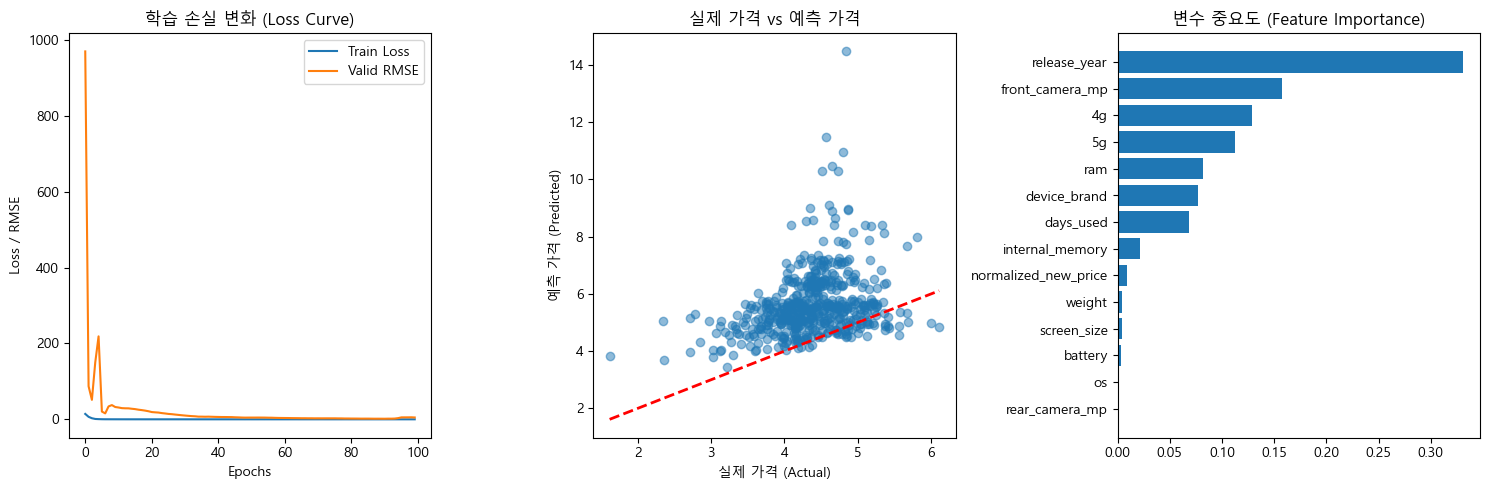

In [6]:
plt.figure(figsize=(15, 5))

# 1. Loss 그래프 (학습 진행 상황)
plt.subplot(1, 3, 1)
plt.plot(clf.history['loss'], label='Train Loss')
plt.plot(clf.history['valid_rmse'], label='Valid RMSE')
plt.title('학습 손실 변화 (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss / RMSE')
plt.legend()

# 2. 예측 결과 산점도 (실제값 vs 예측값)
preds = clf.predict(X_test)
plt.subplot(1, 3, 2)
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # 대각선 기준선
plt.title('실제 가격 vs 예측 가격')
plt.xlabel('실제 가격 (Actual)')
plt.ylabel('예측 가격 (Predicted)')

# 3. Feature Importance (주요 변수 중요도)
explain_matrix, masks = clf.explain(X_test)
feature_importances = clf.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.subplot(1, 3, 3)
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title('변수 중요도 (Feature Importance)')

plt.tight_layout()
plt.show()